In [1]:
import numpy as np
import pandas as pd
import warnings
import shutil
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf


warnings.filterwarnings("ignore")

/home/stanislav/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-03-02 17:38:38.757249: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-02 17:38:39.473802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-02 17:38:39.477358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 17:38:41.137793: W tensorfl

In [2]:
triplets_df = pd.read_csv("../triplets.csv")
PATH_TO_IMGS = "../images/"

In [3]:
triplets_df.head(5)

,anchor,id1,pos,id2,neg,id3
0,056279.jpg,1,108998.jpg,1,030848.jpg,496
1,024091.jpg,1,000023.jpg,1,093653.jpg,9313
2,122082.jpg,3,045833.jpg,3,188283.jpg,7200
3,110393.jpg,3,021233.jpg,3,178433.jpg,4643
4,101388.jpg,4,056784.jpg,4,105432.jpg,2988


## Utils 

In [4]:
def display_triplet(triplets_df, triplet_id):
    # Load the images


    triplet = triplets_df.iloc[triplet_id]

    
    anchor_img = mpimg.imread(PATH_TO_IMGS + triplet["anchor"])
    pos_img = mpimg.imread(PATH_TO_IMGS + triplet["pos"])
    neg_img = mpimg.imread(PATH_TO_IMGS + triplet["neg"])
    
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    
    # Display each image
    axs[0].imshow(anchor_img)
    axs[0].set_title('Anchor Image')
    axs[0].axis('off') 
    
    axs[1].imshow(pos_img)
    axs[1].set_title('Positive Image')
    axs[1].axis('off')  
    
    axs[2].imshow(neg_img)
    axs[2].set_title('Negative Image')
    axs[2].axis('off')  
    
    plt.show()

In [5]:
def parse_csv_line(line):
    columns = ['anchor', 'id1', 'pos', 'id2', 'neg', 'id3']
    
    # Decode the CSV line
    record_defaults = [''] * 6  # All fields are strings
    parsed_line = tf.io.decode_csv(line, record_defaults)
    parsed_line = dict(zip(columns, parsed_line))
    return parsed_line


def load_and_preprocess_image(path):
    
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])
    image = image / 255.0
    return image



def create_triplet_dataset(csv_file_path, batch_size=32):
    dataset = tf.data.TextLineDataset(csv_file_path)
    # Skip the header line
    dataset = dataset.skip(1)
    
    # Parse each line
    dataset = dataset.map(lambda line: parse_csv_line(line))
    # Load and preprocess the images
    def load_images(parsed_line):

        base_path = tf.constant(PATH_TO_IMGS)
        
        anchor_path = tf.strings.join([base_path, parsed_line['anchor']], separator='')
        pos_path = tf.strings.join([base_path, parsed_line['pos']], separator='')
        neg_path = tf.strings.join([base_path, parsed_line['neg']], separator='')

        
        anchor = load_and_preprocess_image(anchor_path)
        pos = load_and_preprocess_image(pos_path)
        neg = load_and_preprocess_image(neg_path)
        return anchor, pos, neg

    
    dataset = dataset.map(load_images)
    dataset = dataset.batch(batch_size)
    return dataset


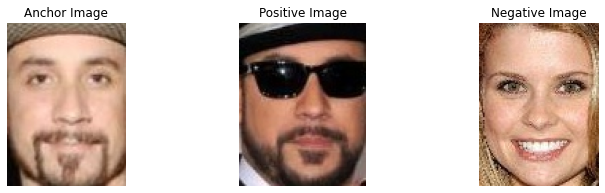

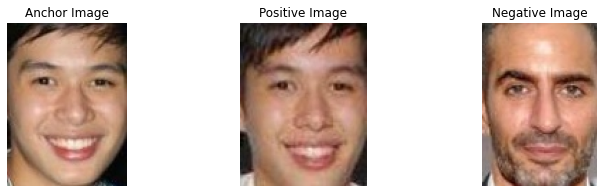

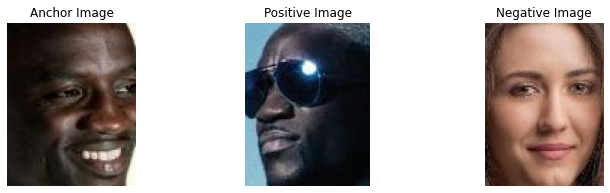

In [6]:
display_triplet(triplets_df, 3)
display_triplet(triplets_df, 7)
display_triplet(triplets_df, 9)

In [7]:
os.path.join(PATH_TO_IMGS, "hello.jpg")

'../images/hello.jpg'

In [8]:
dataset = create_triplet_dataset("../triplets.csv")

In [9]:
batch = next(iter(dataset.take(1)))

In [10]:
from building_model import SiameseModel, build_siamesenetwork, build_embedding_generator



emb_gen = build_embedding_generator(k_layers_to_tune=5)

siam_net = build_siamesenetwork(emb_gen)

siamese_model = SiameseModel(siam_net, margin=0.5)

In [11]:
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
                      )

siamese_model.fit(batch, epochs=40,
                  )

Epoch 1/40
1/1 [==============================] - 23s 23s/step - loss: 0.5071
Epoch 2/40
1/1 [==============================] - 1s 1s/step - loss: 0.4996
Epoch 3/40
1/1 [==============================] - 1s 1s/step - loss: 0.4970
Epoch 4/40
1/1 [==============================] - 1s 1s/step - loss: 0.4940
Epoch 5/40
1/1 [==============================] - 1s 1s/step - loss: 0.4905
Epoch 6/40
1/1 [==============================] - 1s 1s/step - loss: 0.4841
Epoch 7/40
1/1 [==============================] - 1s 1s/step - loss: 0.4710
Epoch 8/40
1/1 [==============================] - 2s 2s/step - loss: 0.4496
Epoch 9/40
1/1 [==============================] - 1s 1s/step - loss: 0.3991
Epoch 10/40
1/1 [==============================] - 1s 1s/step - loss: 0.2911
Epoch 11/40
1/1 [==============================] - 1s 1s/step - loss: 0.0868
Epoch 12/40
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00
Epoch 13/40
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+0

KeyboardInterrupt: 

In [12]:

anch_embs = emb_gen.predict(batch[0])
pos_embs = emb_gen.predict(batch[1])
neg_embs = emb_gen.predict(batch[2])

1/1 [==============================] - 0s 442ms/step


In [13]:


d_pos = tf.reduce_mean(tf.square(anch_embs - pos_embs), axis=0)
d_neg = tf.reduce_mean(tf.square(anch_embs - neg_embs), axis=0)

In [14]:
anch_embs[0]

array([ 0.07744558, -0.06126307, -0.01660451,  0.07370296, -0.08686429,
        0.1524355 , -0.04422272,  0.04079749,  0.1029012 ,  0.02873857,
       -0.0565484 ,  0.11619243, -0.07853293, -0.02427428, -0.03350588,
       -0.04401196, -0.14764005,  0.15046567, -0.02091471,  0.16196856,
        0.15231316, -0.17232178,  0.01749742, -0.02132463, -0.13198178,
        0.00909219, -0.05189737,  0.04245139,  0.09906518, -0.06643622,
       -0.02587024,  0.02832572, -0.04623999, -0.0042227 , -0.05397557,
        0.08964223, -0.03786186, -0.23848987, -0.1403479 ,  0.10163621,
        0.09691885, -0.03109894, -0.20757309,  0.03152042,  0.13160153,
       -0.06539151,  0.01105751,  0.04134001, -0.0316107 ,  0.05444172,
        0.16203056,  0.05627059, -0.08720671,  0.18323153,  0.16043414,
       -0.06568336, -0.14160351, -0.1367889 ,  0.06095911, -0.06516358,
        0.14409985,  0.15366016,  0.01583929, -0.01944421, -0.10910548,
        0.08756882, -0.03571568,  0.01226848, -0.09538089,  0.04

In [15]:
tf.reduce_mean(d_pos)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0005731167>

In [16]:
tf.reduce_mean(d_neg)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00086574943>

In [17]:
cossim = tf.keras.metrics.CosineSimilarity()

In [29]:

# d_neg = d_neg.numpy()
# d_pos = d_pos.numpy()

t = 0.002

np.sum(d_pos <= t)

119

In [30]:
np.sum(d_neg <= t)

108

In [96]:
tf.reduce_mean((d_neg - d_pos))

<tf.Tensor: shape=(), dtype=float32, numpy=3.6023484e-05>

In [99]:
t = 1e-05

